# Air Flow Visualization by Country

This notebook analyzes and visualizes air freight and passenger flows for a selected country. It integrates airport infrastructure data, air OD (Origin-Destination) matrices, and country boundaries to provide insights into inbound and outbound flows at each airport. The workflow includes data loading, filtering, aggregation, visualization, and summary statistics, supporting both freight and passenger air flows. The output includes maps and tables summarizing flows for each airport, with a focus on the selected country.

## 1. Import Required Libraries and Country Boundaries

This section imports all necessary Python libraries and loads the country boundaries dataset. It ensures the spatial data is in the correct coordinate reference system and filters the boundaries to the European region, preparing the context for subsequent air flow analysis.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Point
import networkx as nx
import warnings
from pathlib import Path
import os
import sys

sys.path.append(str(Path().resolve().parent))

from utils.miraca_flow_utils import plot_bubble_map

warnings.filterwarnings('ignore')

base_path = Path(os.path.dirname(os.getcwd()) + "/data")
outpath = Path(os.path.dirname(os.getcwd()) + "/output")

# Load country boundaries
countries_gdf = gpd.read_file(base_path / "helpers" / "ne_10m_admin_0_countries.shp")

# Ensure CRS is WGS84
if countries_gdf.crs is None:
    countries_gdf = countries_gdf.set_crs(4326)
elif countries_gdf.crs.to_epsg() != 4326:
    countries_gdf = countries_gdf.to_crs(4326)

# Filter to Europe region
europe_bounds = {"xmin": -12, "xmax": 32, "ymin": 35, "ymax": 72}
europe_countries = countries_gdf.cx[
    europe_bounds["xmin"]:europe_bounds["xmax"], 
    europe_bounds["ymin"]:europe_bounds["ymax"]
].copy()

print(f"Loaded {len(europe_countries)} countries in Europe region")

Loaded 54 countries in Europe region


## 2. Load air Network and OD Data

This section loads the air network data, including airport locations and air OD (Origin-Destination) matrices for freight and passengers. It identifies the selected country, extracts its geometry, and filters the airport dataset to include only airports within the country's boundaries. This prepares the data for flow aggregation and analysis.

In [2]:
# Load air data
print("Loading air network data...")

air_freight_od = pd.read_parquet(base_path / 'ODs_BE/belgium_air_freight_OD.parquet')
air_passenger_od = pd.read_parquet(base_path / 'ODs_BE/belgium_air_passenger_OD.parquet')
airports_gdf = gpd.read_parquet(base_path / "Infra_BE/belgium_airports.parquet").to_crs("EPSG:4326")

# Set the selected country
SELECTED_COUNTRY = "Belgium"

# Determine the country name column
name_col_candidates = ['ADMIN','NAME','SOVEREIGNT','COUNTRY','COUNTRY_NAME']
name_col = next((c for c in name_col_candidates if c in europe_countries.columns), None)
if name_col is None:
    raise KeyError(f"None of {name_col_candidates} found in country boundaries.")

# Extract country geometry
mask = europe_countries[name_col].astype(str).str.strip().str.lower() == SELECTED_COUNTRY.lower()
country_row = europe_countries[mask]
if country_row.empty:
    raise ValueError(f"Country '{SELECTED_COUNTRY}' not found in boundaries.")
country_geom = country_row.geometry.unary_union

# Filter airports by spatial relation
country_airports = airports_gdf[airports_gdf.within(country_geom)].copy()

# Determine ID column for airports - try multiple candidates
port_id_candidates = ['icao', 'id', 'node_id', 'code', 'UNLOCODE', 'unlocode']
port_id_col = next((c for c in port_id_candidates if c in country_airports.columns), None)
if port_id_col is None:
    raise KeyError(f"Could not find port ID column from {port_id_candidates}")

# Build code lists used for OD filtering
icaos = country_airports[port_id_col].astype(str).tolist()

print("... network loaded")

Loading air network data...
... network loaded
... network loaded


## 3. Calculate air Flows (Inbound and Outbound)

This section filters and aggregates the air OD data to calculate inbound and outbound freight and passenger flows for each port in the selected country. It merges these flows with airport data and prepares summary tables for both freight and passenger movements.

In [3]:
# Filter air freight OD for country airports
air_freight_inbound = air_freight_od[air_freight_od['to_id'].isin(icaos)].copy()
air_freight_outbound = air_freight_od[air_freight_od['from_id'].isin(icaos)].copy()

print(f"air freight flows:")
print(f"  Inbound: {len(air_freight_inbound)} connections")
print(f"  Outbound: {len(air_freight_outbound)} connections")
print(f"  Total inbound flow: {air_freight_inbound['value'].sum():,.0f} tons/day")
print(f"  Total outbound flow: {air_freight_outbound['value'].sum():,.0f} tons/day")

# Aggregate flows by port
air_freight_inbound_agg = air_freight_inbound.groupby('to_id')['value'].sum().reset_index()
air_freight_inbound_agg.columns = ['port_id', 'inbound_flow']

air_freight_outbound_agg = air_freight_outbound.groupby('from_id')['value'].sum().reset_index()
air_freight_outbound_agg.columns = ['port_id', 'outbound_flow']

# Merge with port data and aggregate by icao (combining terminals)
country_airports_flow = country_airports.copy()
country_airports_flow['port_id'] = country_airports_flow[port_id_col].astype(str)

country_airports_flow = country_airports_flow.merge(air_freight_inbound_agg, on='port_id', how='left')
country_airports_flow = country_airports_flow.merge(air_freight_outbound_agg, on='port_id', how='left')

country_airports_flow['inbound_flow'] = country_airports_flow['inbound_flow'].fillna(0)
country_airports_flow['outbound_flow'] = country_airports_flow['outbound_flow'].fillna(0)

# Aggregate by icao, summing flows and using centroid for geometry
agg_dict = {
    'inbound_flow': 'sum',
    'outbound_flow': 'sum',
    'geometry': lambda x: x.unary_union.centroid
}

name_col= 'icao'

country_airports_flow_agg = country_airports_flow.groupby(port_id_col).agg(agg_dict).reset_index()

country_airports_flow_agg = gpd.GeoDataFrame(country_airports_flow_agg, geometry='geometry', crs=country_airports_flow.crs)
country_airports_flow_agg['total_flow'] = country_airports_flow_agg['inbound_flow'] + country_airports_flow_agg['outbound_flow']

# Check if CORRIDOR column exists and merge it
if 'CORRIDORS' in country_airports.columns:
    corridor_map = country_airports[[port_id_col, 'CORRIDORS']].drop_duplicates(subset=[port_id_col])
    country_airports_flow_agg = country_airports_flow_agg.merge(corridor_map, on=port_id_col, how='left')

country_airports_flow = country_airports_flow_agg

print(f"\n✓ Aggregated flows for {len(country_airports_flow)} airports (terminals combined)")

# Filter airenger OD for country airports
air_passenger_inbound = air_passenger_od[air_passenger_od['to_id'].isin(icaos)].copy()
air_passenger_outbound = air_passenger_od[air_passenger_od['from_id'].isin(icaos)].copy()

print(f"\nAir passenger flows:")
print(f"  Inbound: {len(air_passenger_inbound)} connections")
print(f"  Outbound: {len(air_passenger_outbound)} connections")
print(f"  Total inbound flow: {air_passenger_inbound['value'].sum():,.0f} passengers/day")
print(f"  Total outbound flow: {air_passenger_outbound['value'].sum():,.0f} passengers/day")

# Aggregate passenger flows by port
air_passenger_inbound_agg = air_passenger_inbound.groupby('to_id')['value'].sum().reset_index()
air_passenger_inbound_agg.columns = ['port_id', 'inbound_passengers']

air_passenger_outbound_agg = air_passenger_outbound.groupby('from_id')['value'].sum().reset_index()
air_passenger_outbound_agg.columns = ['port_id', 'outbound_passengers']

# Merge with port data and aggregate by icao (combining terminals)
country_airports_passengers = country_airports.copy()
country_airports_passengers['port_id'] = country_airports_passengers[port_id_col].astype(str)

country_airports_passengers = country_airports_passengers.merge(air_passenger_inbound_agg, on='port_id', how='left')
country_airports_passengers = country_airports_passengers.merge(air_passenger_outbound_agg, on='port_id', how='left')

country_airports_passengers['inbound_passengers'] = country_airports_passengers['inbound_passengers'].fillna(0)
country_airports_passengers['outbound_passengers'] = country_airports_passengers['outbound_passengers'].fillna(0)

# Aggregate by icao, summing flows and using centroid for geometry
agg_dict_pass = {
    'inbound_passengers': 'sum',
    'outbound_passengers': 'sum',
    'geometry': lambda x: x.unary_union.centroid
}


country_airports_passengers_agg = country_airports_passengers.groupby(port_id_col).agg(agg_dict_pass).reset_index()

country_airports_passengers_agg = gpd.GeoDataFrame(country_airports_passengers_agg, geometry='geometry', crs=country_airports_passengers.crs)
country_airports_passengers_agg['total_passengers'] = country_airports_passengers_agg['inbound_passengers'] + country_airports_passengers_agg['outbound_passengers']

# Check if CORRIDOR column exists and merge it
if 'CORRIDORS' in country_airports.columns:
    corridor_map = country_airports[[port_id_col, 'CORRIDORS']].drop_duplicates(subset=[port_id_col])
    country_airports_passengers_agg = country_airports_passengers_agg.merge(corridor_map, on=port_id_col, how='left')

country_airports_passengers = country_airports_passengers_agg

print(f"✓ Aggregated passenger flows for {len(country_airports_passengers)} airports (terminals combined)")


air freight flows:
  Inbound: 6 connections
  Outbound: 1 connections
  Total inbound flow: 818 tons/day
  Total outbound flow: 0 tons/day

✓ Aggregated flows for 42 airports (terminals combined)

Air passenger flows:
  Inbound: 110 connections
  Outbound: 102 connections
  Total inbound flow: 109,306,168 passengers/day
  Total outbound flow: 114,859,784 passengers/day
✓ Aggregated passenger flows for 42 airports (terminals combined)


## 4. Visualize Air Flows

This section generates visualizations of air flows using bubble maps. It displays inbound and outbound freight and passenger flows for each airport, highlighting the spatial distribution and magnitude of flows across the selected country's airports.

Generating bubble map subplots...


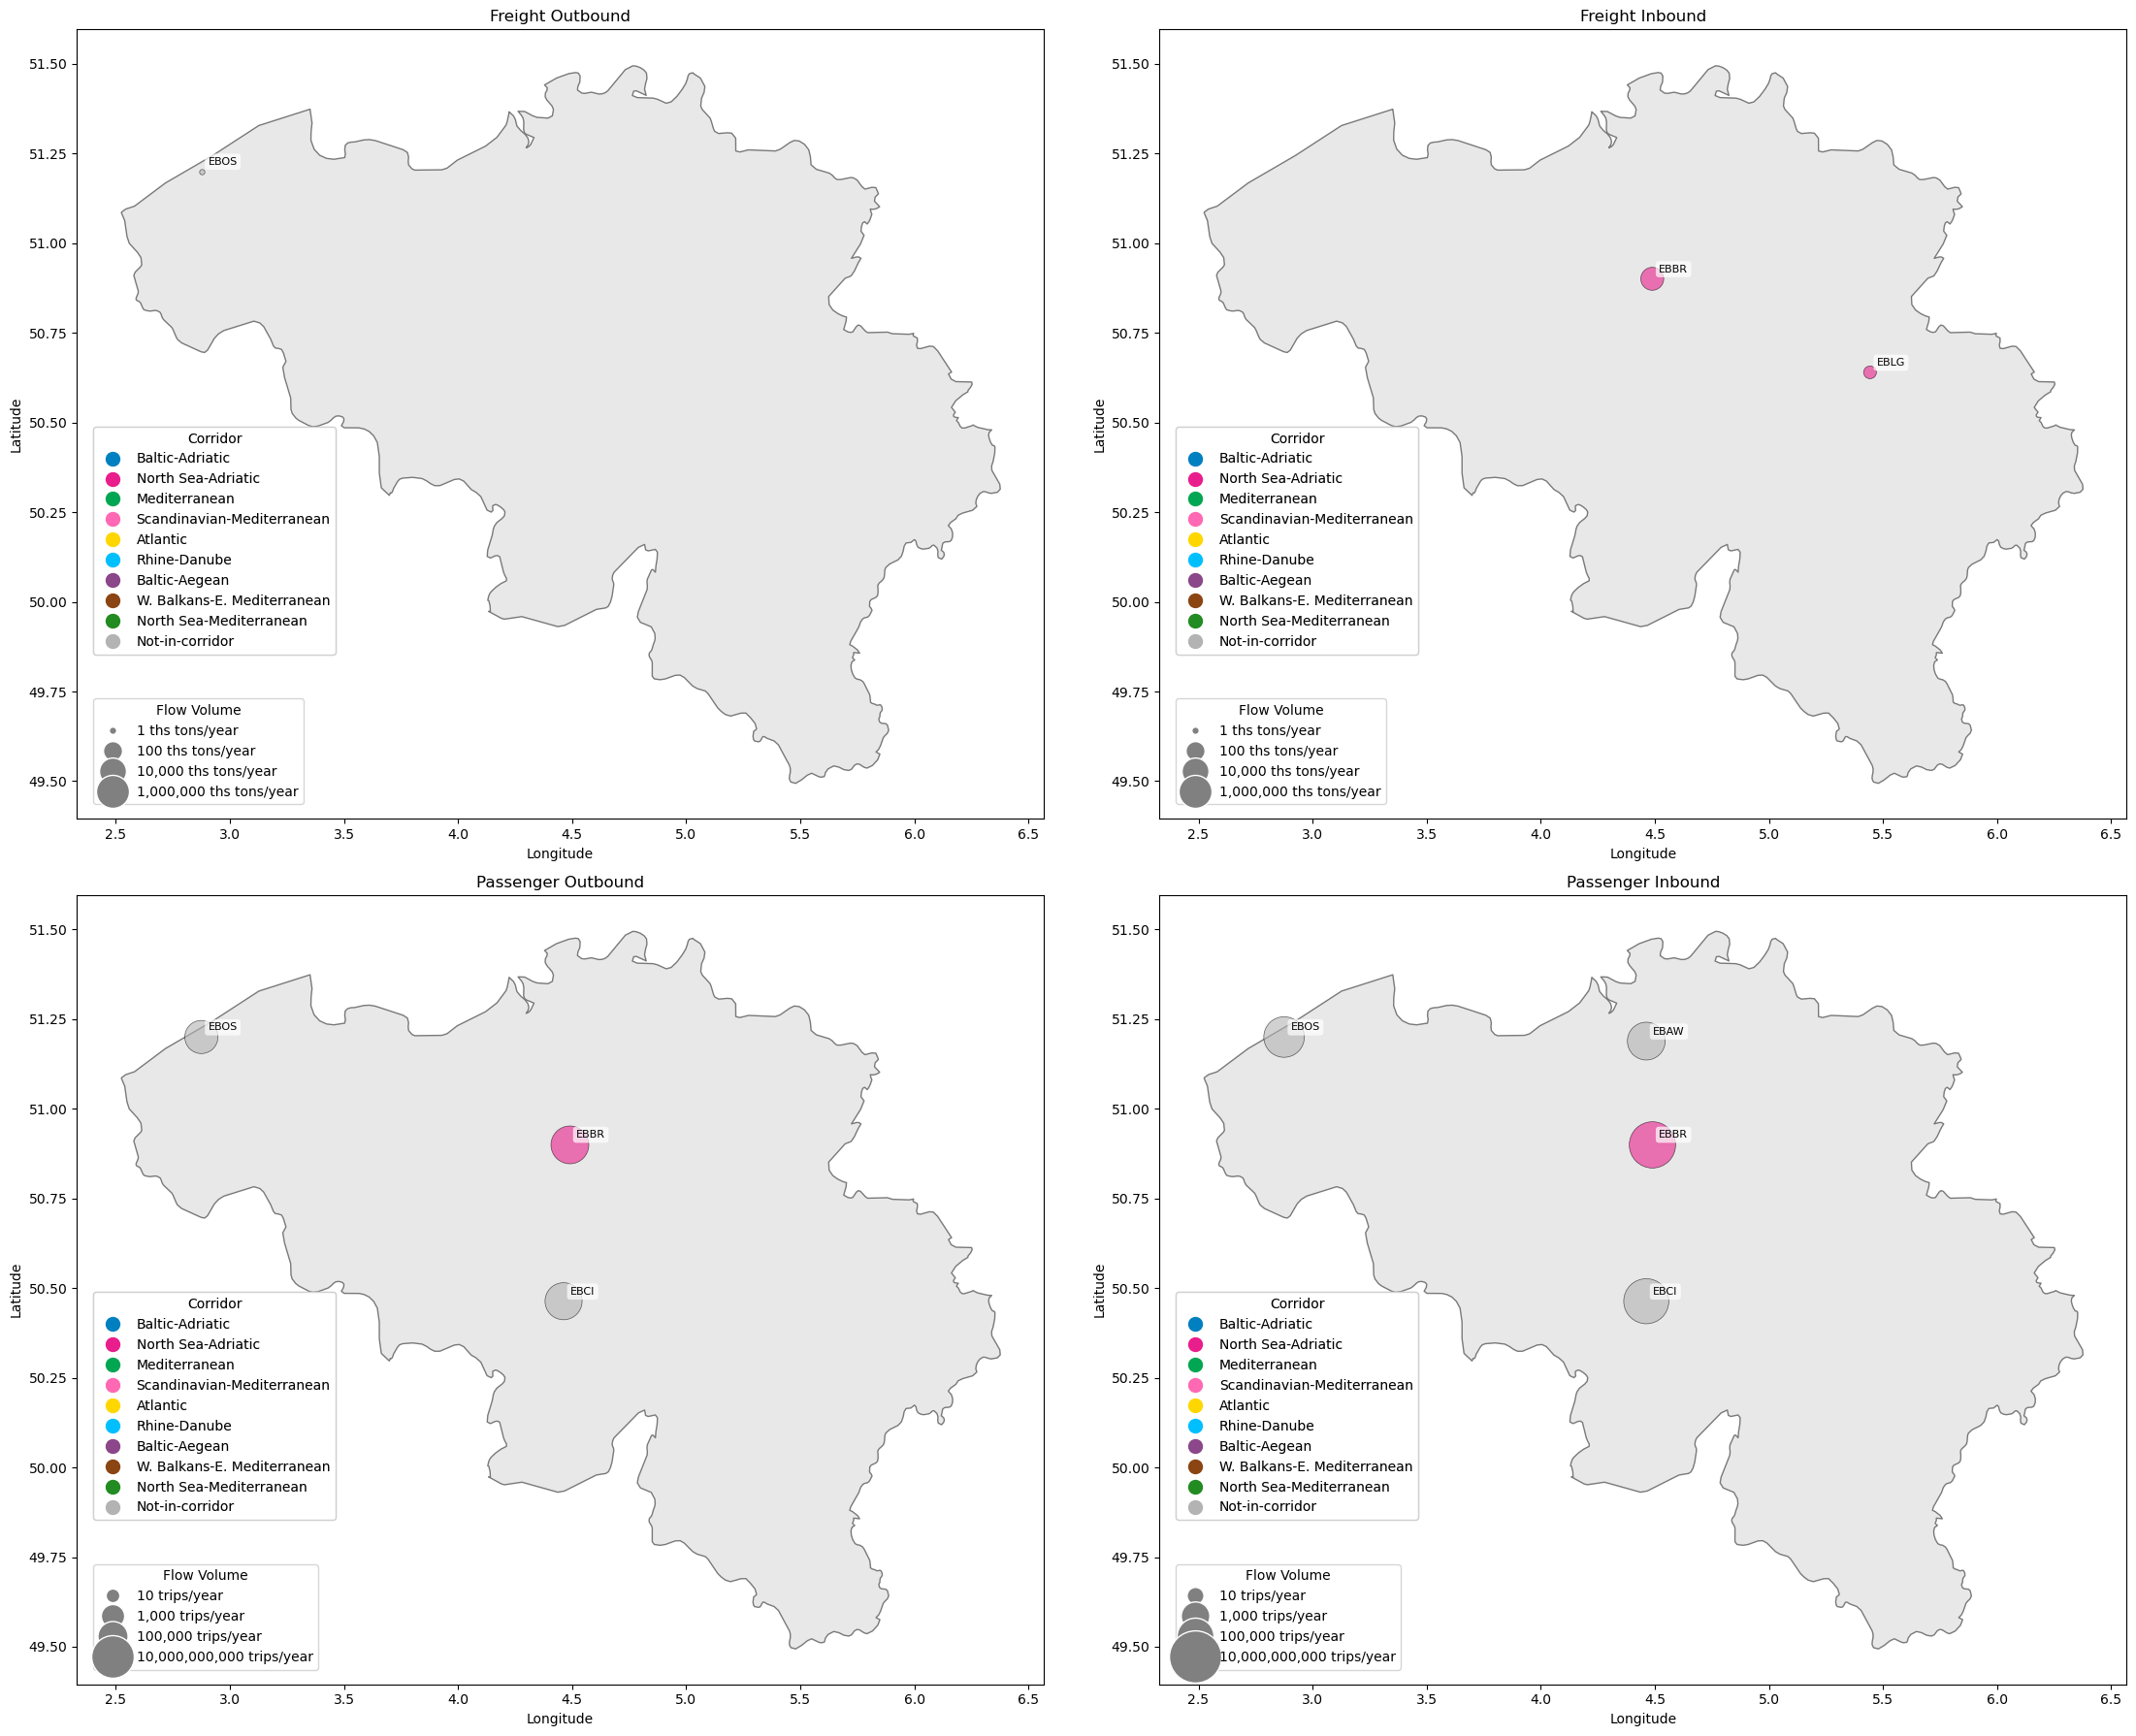

In [4]:
# Visualize all air flows
print("Generating bubble map subplots...")
country_name='BELGIUM'
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
axes = axes.flatten()

# 1. Freight Outbound
plot_bubble_map(
    axes[0], country_airports_flow, 'outbound_flow', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Outbound', 'Freight', outpath, scale_factor=100, flow_values=[1, 100, 10000, 1000000]
)
axes[0].set_title('Freight Outbound')

# 2. Freight Inbound
plot_bubble_map(
    axes[1], country_airports_flow, 'inbound_flow', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Inbound', 'Freight', outpath, scale_factor=100, flow_values=[1, 100, 10000, 1000000]
)
axes[1].set_title('Freight Inbound')

# 3. Passenger Outbound
plot_bubble_map(
    axes[2], country_airports_passengers, 'outbound_passengers', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Outbound', 'Passenger', outpath, scale_factor=100, flow_values=[10, 1000, 100000, 10000000000]
)
axes[2].set_title('Passenger Outbound')

# 4. Passenger Inbound
plot_bubble_map(
    axes[3], country_airports_passengers, 'inbound_passengers', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Inbound', 'Passenger', outpath, scale_factor=150, flow_values=[10, 1000, 100000, 10000000000]
)
axes[3].set_title('Passenger Inbound')

filename = f'Air_bubbles_{country_name.replace(" ", "_")}.png'
plt.savefig(outpath / filename, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 5. Summary Statistics

This section provides summary statistics for the selected country's air infrastructure and flows. It reports the number of airports, total inbound and outbound freight and passenger flows, and net flows, offering a concise overview of the country's air activity.

In [6]:
print("="*60)
print(f"SUMMARY FOR {SELECTED_COUNTRY}")
print("="*60)
print(f"\nInfrastructure:")
print(f"  Ports: {len(country_airports)}")

print(f"\nAir Freight Flows:")
print(f"  Airports with inbound flow: {(country_airports_flow['inbound_flow'] > 0).sum()}")
print(f"  Airports with outbound flow: {(country_airports_flow['outbound_flow'] > 0).sum()}")
print(f"  Total inbound: {country_airports_flow['inbound_flow'].sum():,.0f} tons/day")
print(f"  Total outbound: {country_airports_flow['outbound_flow'].sum():,.0f} tons/day")
print(f"  Net flow: {(country_airports_flow['outbound_flow'].sum() - country_airports_flow['inbound_flow'].sum()):,.0f} tons/day")

print(f"\nAir Passenger Flows:")
print(f"  Airports with inbound flow: {(country_airports_passengers['inbound_passengers'] > 0).sum()}")
print(f"  Airports with outbound flow: {(country_airports_passengers['outbound_passengers'] > 0).sum()}")
print(f"  Total inbound: {country_airports_passengers['inbound_passengers'].sum():,.0f} passengers/day")
print(f"  Total outbound: {country_airports_passengers['outbound_passengers'].sum():,.0f} passengers/day")
print(f"  Net flow: {(country_airports_passengers['outbound_passengers'].sum() - country_airports_passengers['inbound_passengers'].sum()):,.0f} passengers/day")

print("="*60)

SUMMARY FOR Belgium

Infrastructure:
  Ports: 42

Air Freight Flows:
  Airports with inbound flow: 2
  Airports with outbound flow: 1
  Total inbound: 818 tons/day
  Total outbound: 0 tons/day
  Net flow: -818 tons/day

Air Passenger Flows:
  Airports with inbound flow: 4
  Airports with outbound flow: 3
  Total inbound: 109,306,168 passengers/day
  Total outbound: 114,859,784 passengers/day
  Net flow: 5,553,616 passengers/day
